,Date,Type,Value,Year,Skupina
0,2002-01-01,AMBROZIJA,0.0,2002,Alergeni pleveli
1,2002-01-02,AMBROZIJA,0.0,2002,Alergeni pleveli
2,2002-01-03,AMBROZIJA,0.0,2002,Alergeni pleveli
3,2002-01-04,AMBROZIJA,0.0,2002,Alergeni pleveli
4,2002-01-05,AMBROZIJA,0.0,2002,Alergeni pleveli


Type
GABER            7028.000000
KOPRIVOVKE       4264.000000
PRAVI KOSTANJ    3537.026504
JELŠA            2659.000000
TRAVE            2652.000000
CIPRESOVKE       2395.103706
BREZA            2366.147620
BOR              1916.768175
LESKA            1498.000000
JESEN            1491.985011
BUKEV            1024.000000
HRAST             550.000000
PLATANA           477.000000
PELIN             469.694079
AMBROZIJA         448.195615
TRPOTEC           347.000000
KISLICA           200.524414
OLJKA              98.023633
Name: Value, dtype: float64

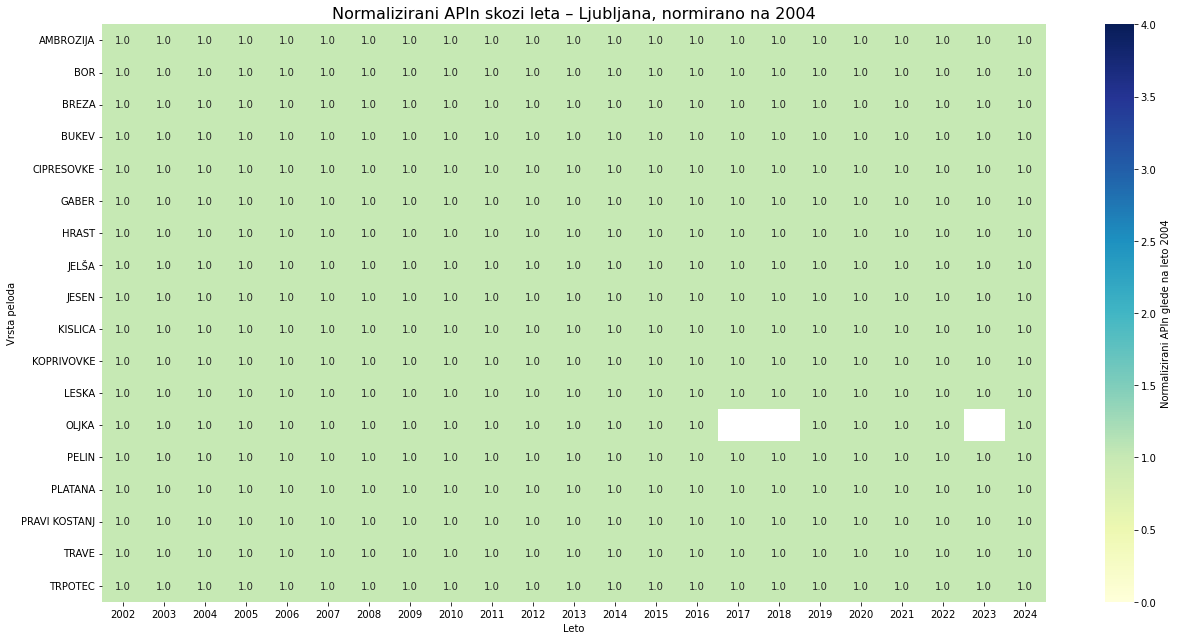

,Date,Type,Value,Year,Skupina
0,2002-01-01,AMBROZIJA,0.0,2002,Alergeni pleveli
1,2002-01-02,AMBROZIJA,0.0,2002,Alergeni pleveli
2,2002-01-03,AMBROZIJA,0.0,2002,Alergeni pleveli
3,2002-01-04,AMBROZIJA,0.0,2002,Alergeni pleveli
4,2002-01-05,AMBROZIJA,0.0,2002,Alergeni pleveli


Type
KOPRIVOVKE       7603.817912
JELŠA            5810.990048
GABER            5462.216417
BREZA            3901.466782
PRAVI KOSTANJ    3451.781638
TRAVE            2971.594081
BOR              2895.955005
CIPRESOVKE       1892.494904
LESKA            1575.703322
JESEN            1089.059825
AMBROZIJA         989.158132
HRAST             888.063462
BUKEV             885.386867
PELIN             658.214589
PLATANA           267.861296
TRPOTEC           263.954268
KISLICA           171.802215
OLJKA              28.266274
Name: Value, dtype: float64

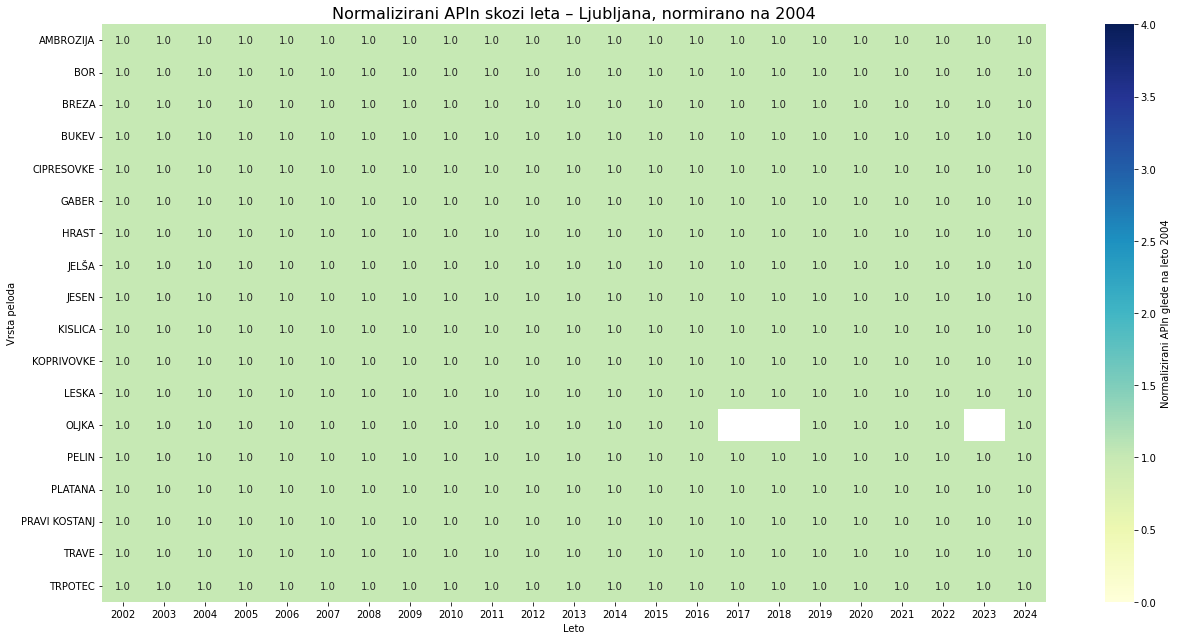

,Date,Type,Value,Year,Skupina
0,2002-01-01,AMBROZIJA,0.0,2002,Alergeni pleveli
1,2002-01-02,AMBROZIJA,0.0,2002,Alergeni pleveli
2,2002-01-03,AMBROZIJA,0.0,2002,Alergeni pleveli
3,2002-01-04,AMBROZIJA,0.0,2002,Alergeni pleveli
4,2002-01-05,AMBROZIJA,0.0,2002,Alergeni pleveli


Type
CIPRESOVKE       7635.132305
GABER            6777.000000
KOPRIVOVKE       2224.055353
TRAVE            1567.882457
BOR              1502.553129
OLJKA            1414.000000
JESEN            1379.000000
PRAVI KOSTANJ    1148.546764
JELŠA             769.000000
LESKA             625.000000
HRAST             585.000000
PLATANA           485.893863
AMBROZIJA         421.108271
BUKEV             286.114432
TRPOTEC           214.000000
BREZA             167.000000
PELIN             161.543902
KISLICA            74.416083
Name: Value, dtype: float64

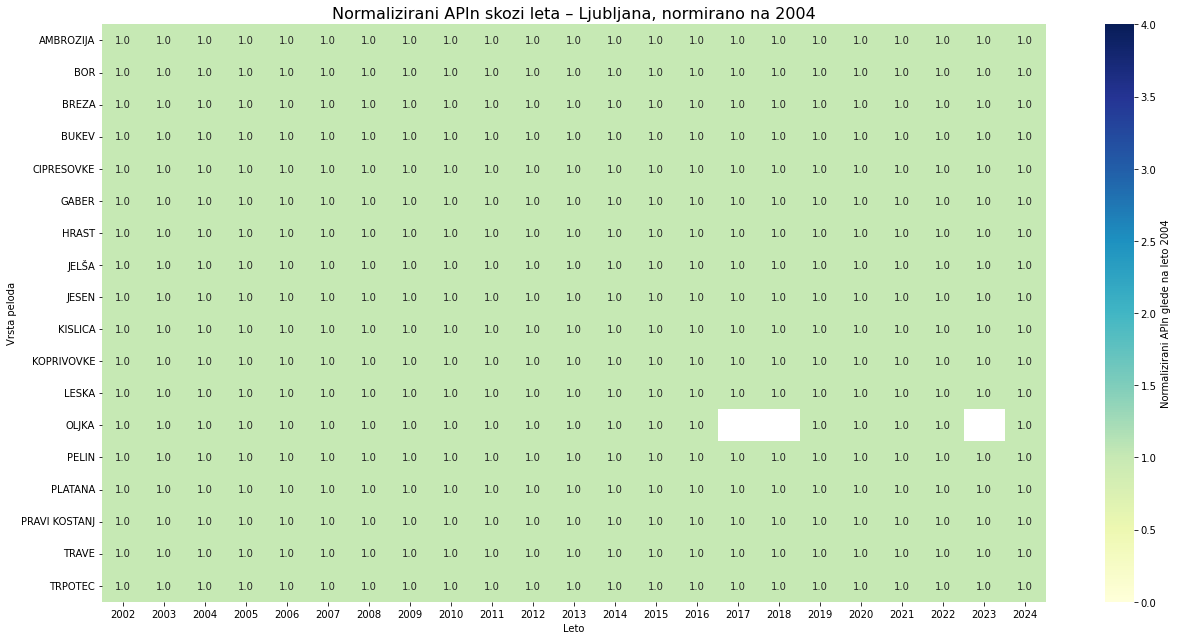

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


location = ["Ljubljana", "Maribor", "Primorje"]
for loc in location:
    path = os.path.join("data", "processed", f"{loc}_processed.csv")

    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    display(df.head())
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value'].sort_values(ascending=False)
    display(ref_sums)
    def norm_to_ref(row):
        ref = ref_sums.get(row['Type'], np.nan)
        return row['Value'] / ref if pd.notnull(ref) and ref != 0 else np.nan

    df_sum['Normalized_APIn'] = df_sum.apply(norm_to_ref, axis=1)
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')


    path = os.path.join("data", "processed", "Ljubljana_processed.csv")
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # 1. Calculate annual sums
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()

    # 2. Reference year normalization
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value']
    df_sum['Normalized_APIn'] = df_sum.apply(
        lambda row: row['Value'] / ref_sums.get(row['Type'], np.nan) if pd.notnull(ref_sums.get(row['Type'], np.nan)) and ref_sums.get(row['Type'], np.nan) != 0 else np.nan,
        axis=1
    )
    
    # 2.1 Normalite by yearly APIn
    yearly_totals = df_sum.groupby(['Year', 'Type'])['Value'].sum().reset_index()
    yearly_totals = yearly_totals.rename(columns={'Value': 'APIn_Year_Type'})
    df_sum = pd.merge(df_sum, yearly_totals, on=['Year', 'Type'], how='left')

    df_sum['Normalized_APIn'] = df_sum.apply(
        lambda row: row['Value'] / row['APIn_Year_Type'] if row['APIn_Year_Type'] > 0 else np.nan,
        axis=1
    )
    # Na koncu lahko zbrišemo pomožni stolpec APIn_Year_Type
    df_sum = df_sum.drop(columns=['APIn_Year_Type'])

    # 3. Pivot for heatmap
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')

    # 4. Plot
    plt.figure(figsize=(18, 9))
    ax = sns.heatmap(
        heatmap_df, 
        annot=True, 
        fmt=".1f", 
        cmap="YlGnBu",
        vmax = 4,
        vmin = 0,
        cbar_kws={"label": f"Normalizirani APIn glede na leto {ref_year}"}
    )
    plt.title(f"Normalizirani APIn skozi leta – Ljubljana, normirano na {ref_year}", fontsize=16)
    plt.xlabel("Leto")
    plt.ylabel("Vrsta peloda")
    plt.tight_layout()
    plt.savefig(os.path.join("results", f"{loc}_heatmap_norm_{ref_year}.png"), dpi=300)
    plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns

# Load JSON data from the files containing detailed yearly results (the *_results_2.json files)
files = {
    "Ljubljana": os.path.join("results","Ljubljana_results_2_norm.json"),
    "Maribor": os.path.join("results","Maribor_results_2_norm.json"),
    "Primorje": os.path.join("results","Primorje_results_2_norm.json")
}

data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", "Start", "Location"]])
# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)

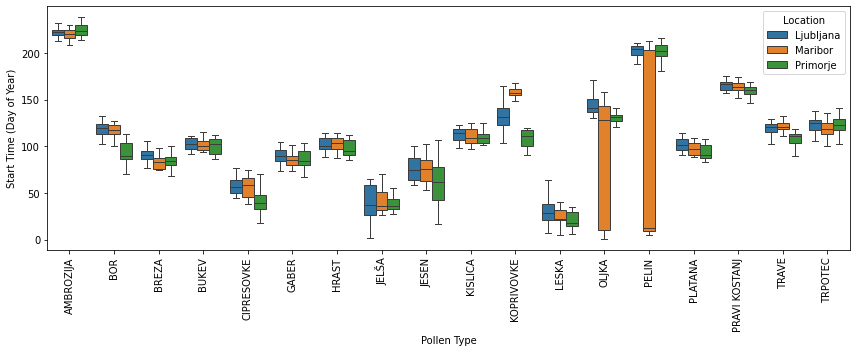

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
4,BOR,Ljubljana vs Primorje,1.879519e-07,0.000010,True
5,BOR,Maribor vs Primorje,4.235407e-07,0.000023,True
13,CIPRESOVKE,Ljubljana vs Primorje,2.189492e-05,0.001182,True
14,CIPRESOVKE,Maribor vs Primorje,2.310029e-04,0.012474,True
30,KOPRIVOVKE,Ljubljana vs Maribor,6.591746e-06,0.000356,True
31,KOPRIVOVKE,Ljubljana vs Primorje,4.773869e-05,0.002578,True
32,KOPRIVOVKE,Maribor vs Primorje,4.955534e-08,0.000003,True
37,OLJKA,Ljubljana vs Primorje,2.562053e-04,0.013835,True
39,PELIN,Ljubljana vs Maribor,4.330360e-04,0.023384,True
41,PELIN,Maribor vs Primorje,8.646989e-04,0.046694,True


-------------------- Mann-Whitney U Test Results --------------------


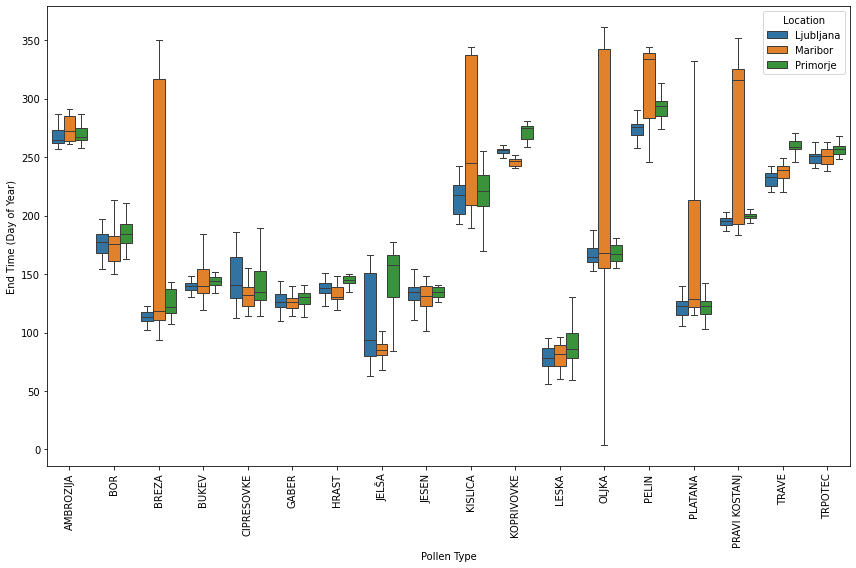

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
7,BREZA,Ljubljana vs Primorje,1.037066e-04,5.600157e-03,True
19,HRAST,Ljubljana vs Primorje,6.571286e-04,3.548494e-02,True
20,HRAST,Maribor vs Primorje,7.518052e-06,4.059748e-04,True
23,JELŠA,Maribor vs Primorje,4.142429e-06,2.236912e-04,True
30,KOPRIVOVKE,Ljubljana vs Maribor,1.751363e-07,9.457361e-06,True
31,KOPRIVOVKE,Ljubljana vs Primorje,4.773585e-07,2.577736e-05,True
32,KOPRIVOVKE,Maribor vs Primorje,1.638201e-08,8.846286e-07,True
39,PELIN,Ljubljana vs Maribor,2.213376e-04,1.195223e-02,True
40,PELIN,Ljubljana vs Primorje,2.527420e-06,1.364807e-04,True
49,TRAVE,Ljubljana vs Primorje,6.406915e-09,3.459734e-07,True


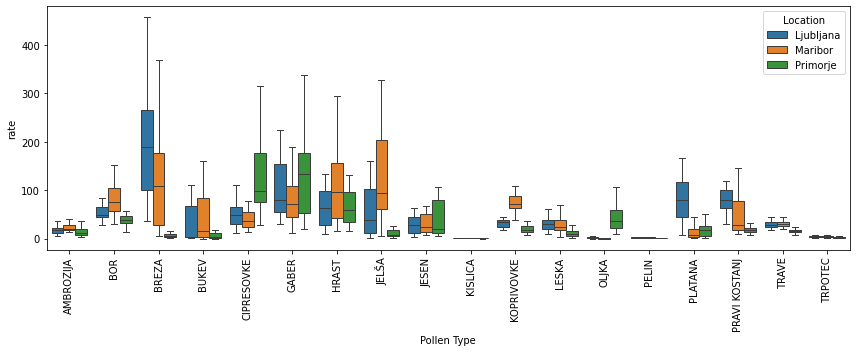

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
5,BOR,Maribor vs Primorje,3.624384e-05,1.957167e-03,True
7,BREZA,Ljubljana vs Primorje,6.636886e-09,3.583918e-07,True
8,BREZA,Maribor vs Primorje,2.163320e-07,1.168193e-05,True
13,CIPRESOVKE,Ljubljana vs Primorje,2.049857e-04,1.106923e-02,True
14,CIPRESOVKE,Maribor vs Primorje,1.202720e-06,6.494690e-05,True
23,JELŠA,Maribor vs Primorje,4.351255e-07,2.349678e-05,True
28,KISLICA,Ljubljana vs Primorje,3.986913e-05,2.152933e-03,True
30,KOPRIVOVKE,Ljubljana vs Maribor,1.641481e-08,8.863995e-07,True
31,KOPRIVOVKE,Ljubljana vs Primorje,1.207460e-04,6.520283e-03,True
32,KOPRIVOVKE,Maribor vs Primorje,9.811472e-09,5.298195e-07,True


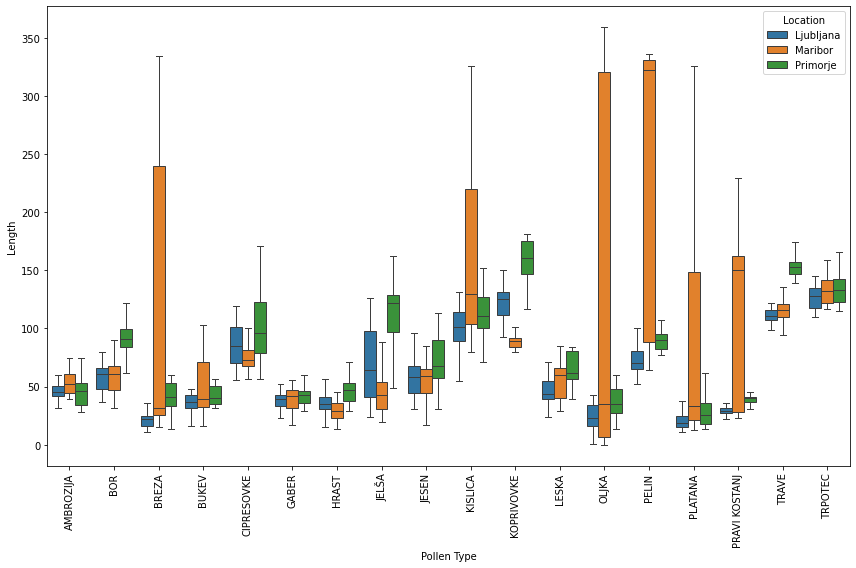

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
4,BOR,Ljubljana vs Primorje,1.184452e-07,6.396041e-06,True
5,BOR,Maribor vs Primorje,1.920589e-05,1.037118e-03,True
6,BREZA,Ljubljana vs Maribor,6.514889e-04,3.518040e-02,True
7,BREZA,Ljubljana vs Primorje,5.621767e-06,3.035754e-04,True
14,CIPRESOVKE,Maribor vs Primorje,9.031242e-04,4.876870e-02,True
20,HRAST,Maribor vs Primorje,3.572473e-05,1.929135e-03,True
23,JELŠA,Maribor vs Primorje,1.485471e-06,8.021544e-05,True
30,KOPRIVOVKE,Ljubljana vs Maribor,1.953491e-08,1.054885e-06,True
31,KOPRIVOVKE,Ljubljana vs Primorje,1.758816e-06,9.497608e-05,True
32,KOPRIVOVKE,Maribor vs Primorje,6.524487e-09,3.523223e-07,True


In [19]:
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 5))


sns.boxplot(data=combined_df, x="Type", y="Start", hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("Start Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


from scipy.stats import mannwhitneyu
import itertools
import statsmodels.stats.multitest as smm


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", "Start", "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1]["Start"].values
        group2 = data_subset[data_subset["Location"] == loc2]["Start"].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}:")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
significant_results.head(20)
display(significant_results.head(20))
print(f"{20*'-'} Mann-Whitney U Test Results {20*'-'}")
### ---------------------------------------------------- ###

var = "End"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("End Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))


### ---------------------------------------------------- ###

var = "rate"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 5))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

### ---------------------------------------------------- ###

var = "Length"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

In [30]:
import pandas as pd
import json

# Load summary files with CP (APIn) values
files_summary = {
    "Ljubljana": os.path.join("results","Ljubljana_results_norm.json"),
    "Maribor": os.path.join("results","Maribor_results_norm.json"),
    "Primorje": os.path.join("results","Primorje_results_norm.json")
}

apin_data = []
# Extract CP info for each pollen type and location
for location, filepath in files_summary.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    for pollen, values in content.items():
        if "CP" in values:
            apin_data.append({
                "Location": location,
                "Pollen": pollen,
                "Trend": values["CP"].get("Trend", None),
                "Intercept": values["CP"].get("Intercept", None),
                "R2": values["CP"].get("R2", None),
                "min_CP": values["CP"].get("min", None),
                "avg_CP": values["CP"].get("avg", None),
                "max_CP": values["CP"].get("max", None)
            })
print(f"{20*'-'} APIn Summary Data {20*'-'}")
apin_df = pd.DataFrame(apin_data)
apin_df = apin_df.sort_values(by=["R2"], ascending=False)
# Show the first rows to inspect
display(apin_df.head(10))
apin_df.to_excel("apin_summary_CP.xlsx", index=False)

for var in ["K10", "K90", "Length"]:
    apin_data = []
    for location, filepath in files_summary.items():
        with open(filepath, "r", encoding="utf-8") as f:
            content = json.load(f)
        #print(f"Processing {location} for variable {var}...")
        for pollen, values in content.items():
            #print(f"Processing pollen type: {pollen, var, values}")
            if var in values:
                apin_data.append({
                    "Location": location,
                    "Pollen": pollen,
                    "Trend": values[var].get("Trend", None),
                    "Intercept": values[var].get("Intercept", None),
                    "R2": values[var].get("R2", None),
                    "min": values[var].get("min", None),
                    "avg": values[var].get("avg", None),
                    "max": values[var].get("max", None)
                })
    print(f"{20*'-'} {var} Summary Data {20*'-'}")
    apin_df = pd.DataFrame(apin_data)
    apin_df = apin_df.sort_values(by=["R2"], ascending=False)
    # Show the first rows to inspect
    display(apin_df.head(10))
    apin_df.to_excel(f"apin_summary_{var}.xlsx", index=False)

-------------------- APIn Summary Data --------------------


,Location,Pollen,Trend,Intercept,R2,min_CP,avg_CP,max_CP
22,Maribor,CIPRESOVKE,177.972332,-355128.222242,0.769340,1117.597906,3130.081478,6196.164039
31,Maribor,PELIN,-18.917291,38431.705598,0.604392,144.000000,351.199329,657.266390
46,Primorje,KOPRIVOVKE,196.003105,-390973.495870,0.548752,1437.789648,3580.754421,8176.486756
13,Ljubljana,PELIN,-10.550930,21455.081597,0.517116,89.000000,216.060070,469.694079
28,Maribor,KOPRIVOVKE,190.902931,-377241.215247,0.497045,3678.000000,7046.385660,10761.507237
34,Maribor,TRAVE,96.433790,-190299.514986,0.483042,2642.613852,3821.703830,5680.332445
4,Ljubljana,CIPRESOVKE,240.605808,-479666.081861,0.478660,1794.000000,4673.410283,11742.977709
35,Maribor,TRPOTEC,29.214910,-58141.487619,0.473723,253.821000,668.127179,1434.425939
10,Ljubljana,KOPRIVOVKE,112.758638,-222896.414117,0.455672,2422.418287,4086.723918,5901.000000
9,Ljubljana,KISLICA,-4.771422,9727.378164,0.454257,43.000000,122.505518,210.834145


-------------------- K10 Summary Data --------------------


,Location,Pollen,Trend,Intercept,R2,min,avg,max
31,Maribor,PELIN,11.974308,-24016.717391,0.729728,5.0,87.565217,213.0
7,Ljubljana,JELŠA,-1.623518,3307.750000,0.416301,2.0,39.608696,65.0
37,Primorje,BOR,-1.116601,2341.021739,0.395924,70.0,93.304348,113.0
10,Ljubljana,KOPRIVOVKE,-1.436759,3025.108696,0.338372,103.0,132.913043,165.0
11,Ljubljana,LESKA,-1.184783,2415.663043,0.273770,7.0,30.695652,64.0
46,Primorje,KOPRIVOVKE,-1.988142,4110.652174,0.271348,15.0,108.521739,159.0
41,Primorje,GABER,-0.741107,1578.282609,0.250865,67.0,86.434783,104.0
42,Primorje,HRAST,-0.617589,1341.728261,0.213759,85.0,98.521739,112.0
28,Maribor,KOPRIVOVKE,-0.317194,796.119565,0.203851,149.0,157.608696,168.0
14,Ljubljana,PLATANA,-0.483202,1074.163043,0.199947,91.0,101.478261,114.0


-------------------- K90 Summary Data --------------------


,Location,Pollen,Trend,Intercept,R2,min,avg,max
33,Maribor,PRAVI KOSTANJ,-9.154150,18690.869565,0.756668,183.0,263.565217,352.0
27,Maribor,KISLICA,-7.245059,14850.434783,0.637853,189.0,266.130435,344.0
31,Maribor,PELIN,-3.492095,7340.760870,0.534585,246.0,311.173913,344.0
34,Maribor,TRAVE,0.907115,-1589.108696,0.515998,215.0,236.913043,249.0
22,Maribor,CIPRESOVKE,-1.223320,2595.021739,0.379972,114.0,132.478261,169.0
30,Maribor,OLJKA,-10.696353,21747.852034,0.375790,4.0,220.954545,361.0
5,Ljubljana,GABER,-0.754941,1647.000000,0.373832,110.0,127.304348,144.0
52,Primorje,TRAVE,0.822134,-1393.913043,0.367957,246.0,261.043478,293.0
14,Ljubljana,PLATANA,-0.721344,1574.543478,0.282844,106.0,122.478261,140.0
13,Ljubljana,PELIN,0.741107,-1217.195652,0.265539,258.0,274.652174,296.0


-------------------- Length Summary Data --------------------


,Location,Pollen,Trend,Intercept,R2,min,avg,max
31,Maribor,PELIN,-15.466403,31357.478261,0.765705,64.0,223.608696,336.0
33,Maribor,PRAVI KOSTANJ,-9.229249,18681.434783,0.747528,23.0,102.956522,229.0
27,Maribor,KISLICA,-7.509881,15276.826087,0.543802,80.0,159.434783,326.0
52,Primorje,TRAVE,1.041502,-1943.456522,0.441246,129.0,153.086957,177.0
46,Primorje,KOPRIVOVKE,2.854743,-5581.945652,0.346889,103.0,164.652174,254.0
28,Maribor,KOPRIVOVKE,0.461462,-840.445652,0.335811,80.0,88.478261,101.0
10,Ljubljana,KOPRIVOVKE,1.417984,-2732.097826,0.328467,93.0,122.304348,150.0
30,Maribor,OLJKA,-12.448107,25187.971248,0.289883,0.0,135.590909,359.0
16,Ljubljana,TRAVE,0.841897,-1583.173913,0.286959,84.0,111.565217,135.0
42,Primorje,HRAST,0.855731,-1676.108696,0.286596,29.0,46.478261,71.0
